

## 1.  Olas de calor: Valor por encima del percentil 90 mensual y anual tanto en tem_max como en tem_min por 3 dias consecutivos



In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# cargar datos y retornar 'Valor'
def load_and_prepare_data(max_path, min_path):

    df_max = pd.read_csv(max_path, parse_dates=True, index_col='Fecha')
    df_min = pd.read_csv(min_path, parse_dates=True, index_col='Fecha')

    return df_max['Valor'], df_min['Valor']

In [ ]:
# calcular percentiles anuales y mensuales
def calculate_percentiles(tem_max, tem_min, percentile=0.9):

    # mensuales
    p90_max_monthly = tem_max.groupby(tem_max.index.month).quantile(percentile)
    p90_min_monthly = tem_min.groupby(tem_min.index.month).quantile(percentile)

    # anuales
    p90_max_annual = tem_max.quantile(percentile)
    p90_min_annual = tem_min.quantile(percentile)

    return p90_max_monthly, p90_min_monthly, p90_max_annual, p90_min_annual

In [ ]:
# función para detectar olas de calor
def detect_heatwaves(mask, tem_max, tem_min, min_duration=6):

    # Máscara de booleans para ver días seguidos
    mask_shifted = mask.ne(mask.shift())
    groups = mask_shifted.cumsum()

    # Filtrar solo secuencias True
    true_sequences = mask[mask].groupby(groups[mask])

    events = []
    for _, group in true_sequences:
        if len(group) >= min_duration:
            start = group.index[0]
            end = group.index[-1]

            # Calcular temperatura promedio en cada ola
            avg_max = tem_max.loc[start:end].mean()
            avg_min = tem_min.loc[start:end].mean()

            # Adjuntar a events con toda la info
            events.append({
                'inicio': start,
                'fin': end,
                'duracion': (end - start).days + 1,
                'media_tem_max': avg_max,
                'media_tem_min': avg_min
            })

    return events

In [ ]:
# Mostrar olas de calor formateadas
def print_heatwaves(heatwaves, title):
  if not heatwaves:
    print(f"\n{title}: No se encontraron olas de calor.")
    return
  else:
    print(f"\n{title}:")
    for event in heatwaves:
        print(f"Del {event['inicio'].date()} al {event['fin'].date()} "
              f"| {event['duracion']} días | "
              f"Tmax: {event['media_tem_max']:.1f}°C | "
              f"Tmin: {event['media_tem_min']:.1f}°C")

In [ ]:
#main

def main():
    # Cargar data
    tem_max, tem_min = load_and_prepare_data('/content/tem_max.csv', '/content/tem_min.csv')

    # Percentiles
    p90_max_monthly, p90_min_monthly, p90_max_annual, p90_min_annual = calculate_percentiles(tem_max, tem_min)

    # Crear mask días olas de calor
    hot_days_annual = (tem_max > p90_max_annual) & (tem_min > p90_min_annual)

    #Ccondición percentil mensual / operación vectorizada
    hot_days_monthly = (
        (tem_max > p90_max_monthly[tem_max.index.month].values) &
        (tem_min > p90_min_monthly[tem_min.index.month].values)
    )

    # Función Detect heatwaves
    heatwaves_annual = detect_heatwaves(hot_days_annual, tem_max, tem_min)
    heatwaves_monthly = detect_heatwaves(hot_days_monthly, tem_max, tem_min)

    # Función Print results
    print_heatwaves(heatwaves_annual, "Olas de calor (percentil 90 anual)")
    print_heatwaves(heatwaves_monthly, "Olas de calor (percentil 90 mensual)")

    return heatwaves_annual, heatwaves_monthly

if __name__ == "__main__":
    df_annual, df_monthly = main()


Olas de calor (percentil 90 anual):
Del 2014-07-15 al 2014-07-21 | 7 días | Tmax: 37.7°C | Tmin: 27.2°C
Del 2015-05-31 al 2015-06-05 | 6 días | Tmax: 38.2°C | Tmin: 27.1°C
Del 2015-07-21 al 2015-07-26 | 6 días | Tmax: 37.2°C | Tmin: 27.1°C
Del 2015-08-30 al 2015-09-10 | 12 días | Tmax: 38.3°C | Tmin: 28.1°C

Olas de calor (percentil 90 mensual):
Del 2015-08-30 al 2015-09-09 | 11 días | Tmax: 38.4°C | Tmin: 28.1°C


In [ ]:
#celda exclusiva para colab, borrar para jupyter
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Extremos de precipitacion: percentil 99 diario mensual y anual! y para todos los anhos!, quizas el pdf y el cdf pueden ser de ayuda?

In [ ]:
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['Fecha'])
    df.set_index('Fecha', inplace=True)
    return df

In [ ]:
def calculate_percentiles(precip_data):

    # Percentil 99 diario
    p99_daily = precip_data['Valor'].quantile(0.99)

    # Percentil 99 mensual
    p99_monthly = precip_data.groupby(precip_data.index.month)['Valor'].quantile(0.99)

    # Percentil 99 anual
    p99_annual = precip_data.groupby(precip_data.index.year)['Valor'].quantile(0.99)

    return p99_daily, p99_monthly, p99_annual

In [ ]:
def analyze_exceedances(precip_data, p99_daily, p99_monthly, p99_annual):

    results = {}

    # Percentil 99 diario
    daily_exceed = precip_data[precip_data['Valor'] > p99_daily]
    years_daily_exceed = daily_exceed.index.year.unique()
    results['daily_99_exceed'] = sorted(years_daily_exceed)

    # Percentil 99 mensual
    monthly_exceed = precip_data.groupby([precip_data.index.year, precip_data.index.month]).apply(
        lambda x: x['Valor'].max() > p99_monthly[x.name[1]]
    )
    years_monthly_exceed = monthly_exceed[monthly_exceed].index.get_level_values(0).unique()
    results['monthly_99_exceed'] = sorted(years_monthly_exceed)

    # Percentil 99 anual
    annual_exceed = precip_data.groupby(precip_data.index.year).apply(
        lambda x: x['Valor'].max() > p99_annual[x.name]
    )
    years_annual_exceed = annual_exceed[annual_exceed].index
    results['annual_99_exceed'] = sorted(years_annual_exceed)

    return results

In [ ]:
def main():
    # Cargar datos
    precip_data = load_and_prepare_data('precipitacion.csv')

    # Calcular percentiles
    p99_daily, p99_monthly, p99_annual = calculate_percentiles(precip_data)

    print(f"Percentil 99 diario: {p99_daily:.2f} mm")
    print("\nPercentil 99 mensual:")
    print(p99_monthly)
    print("\nPercentil 99 anual:")
    print(p99_annual)

    # Analizar exceso
    results = analyze_exceedances(precip_data, p99_daily, p99_monthly, p99_annual)

    print("\nAños sobre percentil diario:")
    print(results['daily_99_exceed'])

    print("\nAños sobre percentil mensual:")
    print(results['monthly_99_exceed'])

    print("\nYAños sobre percentil anual:")
    print(results['annual_99_exceed'])
    return results

    # Histograma
    precip = precip_data['Valor']
    precip = precip.dropna()
    plt.hist(precip, bins=50, density='true', edgecolor='black')
    plt.yscale('log')
    plt.xlabel('Precipitación (mm)')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de Precipitación')
    plt.show()


if __name__ == "__main__":
    analysis_results = main()

Percentil 99 diario: 52.80 mm

Percentil 99 mensual:
Fecha
1     10.516
2      5.005
3      9.395
4     45.800
5     55.412
6     33.270
7     46.230
8     58.208
9     66.775
10    63.410
11    86.612
12    43.064
Name: Valor, dtype: float64

Percentil 99 anual:
Fecha
1988    62.247
1989    79.694
1990    41.436
1991    26.204
1992    16.748
1993    43.800
1994    47.784
1995    38.573
1996    48.586
1997    36.169
1998    43.280
1999    53.584
2000    46.235
2001    41.000
2002    50.718
2003    46.170
2004    55.530
2005    58.000
2006    72.512
2007    63.236
2008    69.875
2009    27.830
2010    65.306
2011    72.460
2012    43.836
2013    33.884
2014    39.500
2015    26.820
2016    51.270
2017    67.568
2018    49.024
2019    30.981
2020    33.510
2021    42.052
2022    64.468
2023    48.929
2024    49.360
2025     7.725
Name: Valor, dtype: float64

Años sobre percentil diario:
[1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,

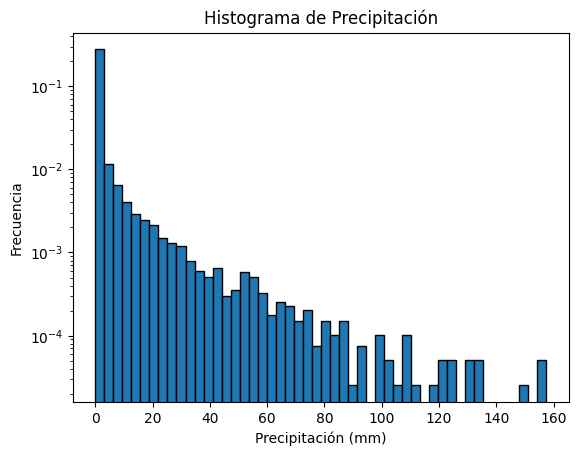

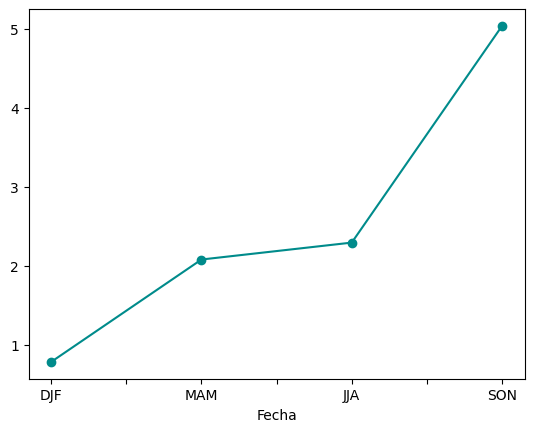

In [ ]:
# Histograma
precip_data = load_and_prepare_data('precipitacion.csv')
# Histograma
precip = precip_data['Valor']
precip = precip.dropna()
plt.hist(precip, bins=50, density='true', edgecolor='black')
plt.yscale('log')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precipitación')
plt.show()

#histograma por estaciones

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    elif month in [9, 10, 11]:
        return 'SON'

seasons = precip.index.month.map(month_to_season)

# Agrupar y calcular promedio
seasonal_mean = precip.groupby(seasons).mean()
seasonal_mean = seasonal_mean.loc[['DJF', 'MAM', 'JJA', 'SON']]

plt.figure(figsize=(10, 6))
plt.hist()
plt.bar(seasonal_mean.index, seasonal_mean.values)
plt.xlabel('Estación del año')
plt.ylabel('Precipitación promedio (mm)')